In [18]:
import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
import re
import pandas as pd
import matplotlib.pyplot as plt

## extract text from 10-k files

In [19]:
import fitz  # PyMuPDF
import os

# 读取 PDF 文件
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text") + "\n"
    return text

# 读取 PDF 文本
text_2023 = extract_text_from_pdf("2023.pdf")
text_2024 = extract_text_from_pdf("2024.pdf")

In [20]:
print(text_2023)

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☒    ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended September 30, 2023
or
☐    TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission File Number: 001-36743
Apple Inc.
(Exact name of Registrant as specified in its charter)
California
94-2404110
(State or other jurisdiction
of incorporation or organization)
(I.R.S. Employer Identification No.)
One Apple Park Way
Cupertino, California
95014
(Address of principal executive offices)
(Zip Code)
(408) 996-1010
(Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each class
Trading 
symbol(s)
Name of each exchange on which registered
Common Stock, $0.00001 par value per share
AAPL
The Nasdaq Stock Market LLC
1.375% N

In [21]:
def extract_item_n(text, n):
    """
    从 10-K 文本中提取 "Item n" 章节的内容，直到 "Item n+1" 之前。
    适配 "Item n." 后**紧跟空格 + 换行** 的情况。
    
    :param text: 10-K 文档文本
    :param n: 需要提取的 Item 编号 (如 7, 8, 9)
    :return: 提取的 "Item n" 章节内容
    """
    # 正则匹配 "Item n." 后必须有空格 + 换行，并匹配完整内容直到 "Item n+1"
    pattern = rf"(?i)item\s*{n}\.\s\n+[\s\S]+?(?=\n\s*item\s*{n+1}|$)"

    match = re.search(pattern, text)

    if match:
        return match.group(0).strip()  # 返回匹配的完整章节
    else:
        print(f"⚠ Warning: 未找到 'Item {n}' 章节，请检查文本格式！")
        return ""

# 运行提取
item_7_2023 = extract_item_n(text_2023,7)
item_7_2024 = extract_item_n(text_2024,7)
# 打印前 1000 个字符，检查是否正确
print(item_7_2023)


Item 7. 
Management’s Discussion and Analysis of Financial Condition and Results of Operations
The following discussion should be read in conjunction with the consolidated financial statements and accompanying notes 
included in Part II, Item 8 of this Form 10-K. This Item generally discusses 2023 and 2022 items and year-to-year comparisons 
between 2023 and 2022. Discussions of 2021 items and year-to-year comparisons between 2022 and 2021 are not included, 
and can be found in “Management’s Discussion and Analysis of Financial Condition and Results of Operations” in Part II, Item 
7 of the Company’s Annual Report on Form 10-K for the fiscal year ended September 24, 2022.
Fiscal Period
The Company’s fiscal year is the 52- or 53-week period that ends on the last Saturday of September. An additional week is 
included in the first fiscal quarter every five or six years to realign the Company’s fiscal quarters with calendar quarters, which 
occurred in the first quarter of 2023. The Compan

In [22]:
print(item_7_2024)

Item 7. 
Management’s Discussion and Analysis of Financial Condition and Results of Operations
The following discussion should be read in conjunction with the consolidated financial statements and accompanying notes 
included in Part II, Item 8 of this Form 10-K. This Item generally discusses 2024 and 2023 items and year-to-year comparisons 
between 2024 and 2023. Discussions of 2022 items and year-to-year comparisons between 2023 and 2022 are not included, 
and can be found in “Management’s Discussion and Analysis of Financial Condition and Results of Operations” in Part II, Item 
7 of the Company’s Annual Report on Form 10-K for the fiscal year ended September 30, 2023.
Product, Service and Software Announcements
The Company announces new product, service and software offerings at various times during the year. Significant 
announcements during fiscal year 2024 included the following:
First Quarter 2024:
•
MacBook Pro 14-in.;
•
MacBook Pro 16-in.; and
•
iMac.
Second Quarter 2024:
•
M

## financial and business analysis

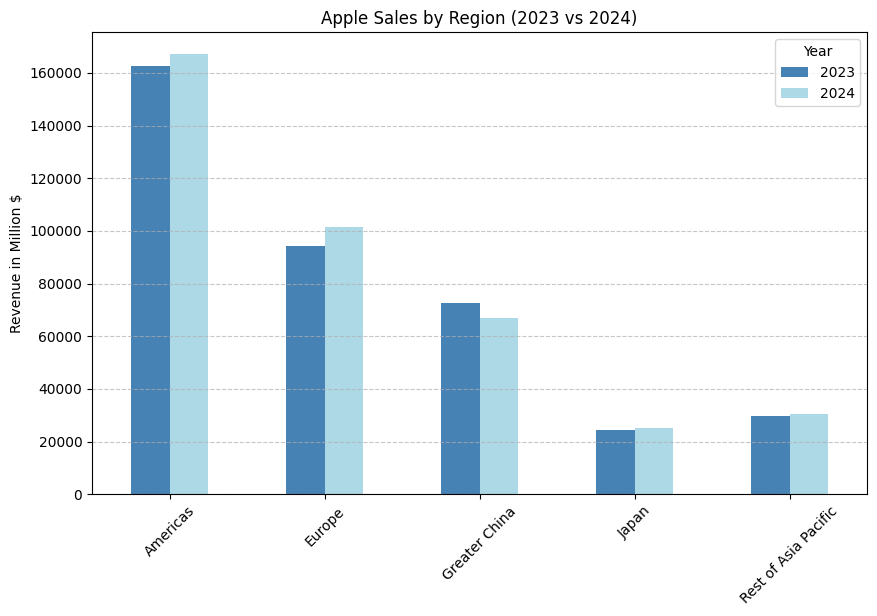

In [ ]:


# 提取财务数据
def extract_financial_data(text):
    pattern = r"(Americas|Europe|Greater China|Japan|Rest of Asia Pacific)\s+\$?\s*([\d,]+)"
    matches = re.findall(pattern, text)

    # 确保所有匹配到的数据转换为整数
    data = {region: int(value.replace(",", "")) for region, value in matches}
    return data


# 假设 text_2024 是文档文本
finance_2024 = extract_financial_data(item_7_2024)
finance_2023 = extract_financial_data(item_7_2023)

# 可视化
df = pd.DataFrame([finance_2023, finance_2024], index=["2023", "2024"]).T

# 绘制柱状图
ax = df.plot(kind="bar", figsize=(10, 6), title="Apple Sales by Region (2023 vs 2024)", ylabel="Revenue in Million $", color = ["steelblue", "lightblue"])

ax.yaxis.grid(True, linestyle="--", alpha=0.7)
# 显示图表
plt.xticks(rotation=0)  # 旋转 x 轴标签，避免重叠
plt.legend(title="Year")  # 设置图例
plt.show()

In [24]:
def extract_product_sales(text):
    """
    提取 iPhone、Mac、iPad、Wearables 和 Services 的销售数据，确保匹配所有格式
    """
    # 先去掉 `(1)` 这样的标注
    text = re.sub(r"\s*\(\d+\)", "", text)

    # 更新正则匹配，确保换行不会影响数据提取
    pattern = r"(iPhone|Mac|iPad|Wearables, Home and Accessories|Services)\s*(?:\$\s*)?\s*\n*([\d,]{4,})(?!\.)"

    matches = re.findall(pattern, text)

    # 解析数据，去掉千位分隔符
    data = {}
    for product, value in matches:
        data[product] = int(value.replace(",", ""))  # 转换为整数
    
    return data


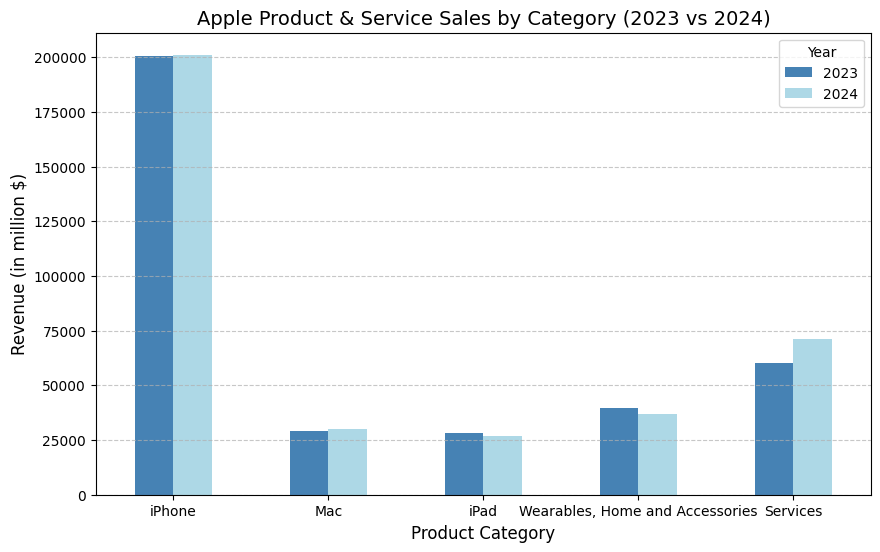

In [25]:

# 从 text_2024 和 text_2023 提取数据
sales_2024 = extract_product_sales(item_7_2024)
sales_2023 = extract_product_sales(item_7_2023)

# 创建 DataFrame
df = pd.DataFrame([sales_2023, sales_2024], index=["2023", "2024"]).T
ax = df.plot(kind="bar", figsize=(10, 6), color=["steelblue", "lightblue"])

# 添加标题 & 轴标签
plt.title("Apple Product & Service Sales by Category (2023 vs 2024)", fontsize=14)
plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Revenue (in million $)", fontsize=12)
plt.xticks(rotation=0)  # 旋转 x 轴标签
plt.legend(title="Year")  # 设置图例标题

# 添加水平网格线
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

# 显示图表
plt.show()

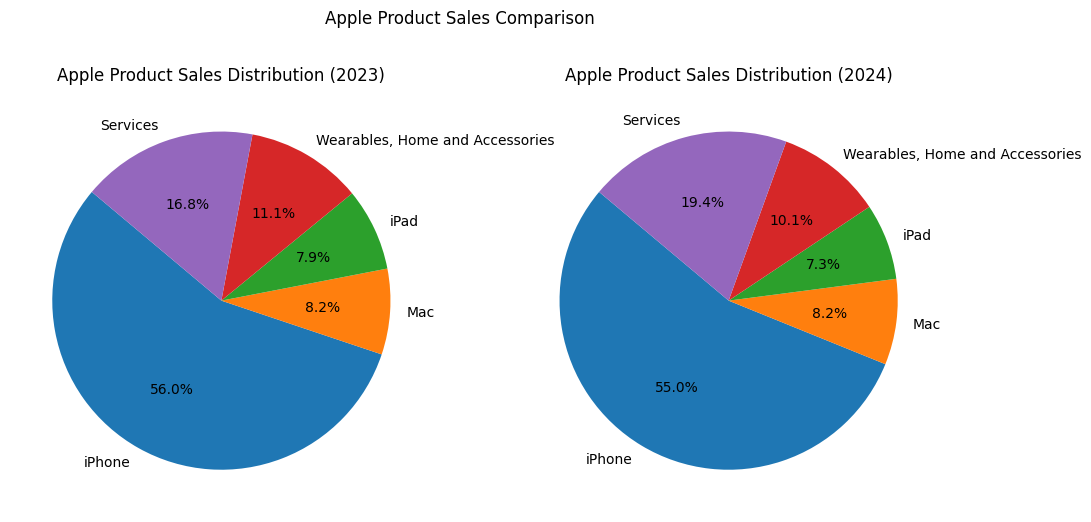

In [26]:
labels = list(sales_2024.keys())  # 产品类别
sizes = list(sales_2024.values())  # 销售额

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
labels1 = list(sales_2023.keys())  # 产品类别
sizes1 = list(sales_2023.values())  # 销售额

labels2 = list(sales_2024.keys())  # 产品类别
sizes2 = list(sales_2024.values())  # 销售额

axes[0].pie(
    sizes1, labels=labels1, autopct='%1.1f%%', startangle=140,
)
axes[0].set_title(f"Apple Product Sales Distribution (2023)")  # 设置标题

axes[1].pie(
    sizes2, labels=labels2, autopct='%1.1f%%', startangle=140,
)
axes[1].set_title(f"Apple Product Sales Distribution (2024)")  # 设置标题

# 添加总标题
plt.suptitle("Apple Product Sales Comparison")

# 显示图表
plt.show()

In [27]:
def extract_apple_2024_products(text):
    """
    提取 Apple 2024 年发布的产品信息
    """
    # 先找到 "Product, Service and Software Announcements" 章节
    pattern = r"Product, Service and Software Announcements[\s\S]+?Fiscal Period"

    match = re.search(pattern, text, re.IGNORECASE)
    
    if not match:
        print("⚠ Warning: 未找到 'Product, Service and Software Announcements' 章节")
        return {}

    product_section = match.group(0)  # 获取完整的产品发布部分

    # 按季度划分
    quarters = ["First Quarter 2024", "Second Quarter 2024", "Third Quarter 2024", "Fourth Quarter 2024"]
    product_data = {}

    for i in range(len(quarters)):
        # 构建正则匹配当前季度到下一个季度之间的产品信息
        if i < len(quarters) - 1:
            quarter_pattern = rf"{quarters[i]}[\s\S]+?(?={quarters[i+1]})"
        else:
            quarter_pattern = rf"{quarters[i]}[\s\S]+?(?=Fiscal Period)"  # 最后一个季度到 Fiscal Period

        quarter_match = re.search(quarter_pattern, product_section)

        if quarter_match:
            # 提取具体产品列表（去掉 bullet points "•"）
            products = re.findall(r"•\s*(.+)", quarter_match.group(0))
            product_data[quarters[i]] = products

    return product_data

# 示例：提取 Apple 2024 发布的产品
apple_2024_products = extract_apple_2024_products(item_7_2024)

# 打印提取结果
for quarter, products in apple_2024_products.items():
    print(f"{quarter}:")
    for product in products:
        print(f"- {product}")

First Quarter 2024:
- MacBook Pro 14-in.;
- MacBook Pro 16-in.; and
- iMac.
Second Quarter 2024:
- MacBook Air 13-in.; and
- MacBook Air 15-in.
Third Quarter 2024:
- iPad Air;
- iPad Pro;
- iOS 18, macOS Sequoia, iPadOS 18, watchOS 11, visionOS 2 and tvOS 18, updates to the Company’s operating 
- Apple Intelligence™, a personal intelligence system that uses generative models.
Fourth Quarter 2024:
- iPhone 16, iPhone 16 Plus, iPhone 16 Pro and iPhone 16 Pro Max;
- Apple Watch Series 10; and
- AirPods 4.


In [43]:
senti_section = extract_item_n(text_2024,7)
business_section = extract_item_n(text_2024,1)

## Risk Analysis ##

In [28]:
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 提取风险部分
risk_section = load_text("risk.txt")

# 计算 TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=20)
tfidf_matrix = vectorizer.fit_transform([risk_section])
terms = vectorizer.get_feature_names_out()

nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

# 获取风险因子的名词短语
risk_noun_phrases = extract_noun_phrases(risk_section)

print("Top Risk Phrases:", risk_noun_phrases[:100])

print("Top Risk Terms:", terms)


Top Risk Phrases: ['Risk Factors', 'The Company’s business', 'reputation', 'results', 'operations', 'financial condition', 'stock price', 'a number', 'factors', 'those', 'these risks', 'time', 'time', 'the Company’s business', 'reputation', 'results', 'operations', 'financial condition', 'stock price', 'the following factors', 'other factors', 'the Company’s results', 'operations', 'financial condition', 'financial performance', 'a reliable indicator', 'future performance', 'investors', 'historical trends', 'results', 'trends', 'future periods', 'This discussion', 'risk factors', 'forward-looking \nstatements', 'This section', 'conjunction', 'Part II', 'Item', 'Management’s Discussion', 'Analysis', 'Financial Condition', 'Results', 'Operations', 'the consolidated financial statements', 'accompanying notes', 'Part II', 'Item', 'Financial \nStatements', 'Supplementary Data', 'this Form 10-K.\n Macroeconomic and Industry Risks\n The Company’s operations', 'performance', 'global and region

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_top_risk_terms(text, top_n=10):
    # 初始化 TF-IDF 向量器
    vectorizer = TfidfVectorizer(stop_words="english", max_features=top_n)
    X = vectorizer.fit_transform([text])

    # 获取特征名（关键词）
    terms = vectorizer.get_feature_names_out()
    
    return terms

# 获取重要风险关键词
top_risk_terms = extract_top_risk_terms(risk_section, top_n=10)

print("Top Risk Terms:", top_risk_terms)


Top Risk Terms: ['adversely' 'business' 'company' 'financial' 'including' 'new'
 'operations' 'products' 'results' 'services']


In [31]:
stop_words = set(stopwords.words('english'))

# 手动添加无意义的词到停用词列表
custom_stopwords = {"apple", "company", "companys","may","including","service","products","the company","apple inc.","example","the u.s.","10-k"}
stop_words.update(custom_stopwords)

In [32]:
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # 移除引用
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 移除非字母字符
    text = text.lower()  # 转换为小写
    words = text.split()  # 将文本按空格分割成单词列表
    words = [word for word in words if word not in stop_words]  # 去除stopwords
    return ' '.join(words)  # 重新组合为文本

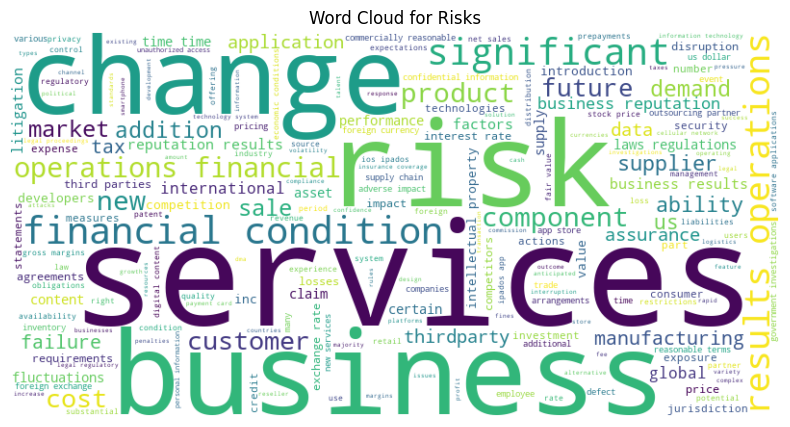

In [33]:
text = " ".join(risk_noun_phrases)
# 重新组合为字符串
cleaned_risk = clean_text(text)

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_risk)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Risks")
plt.show()

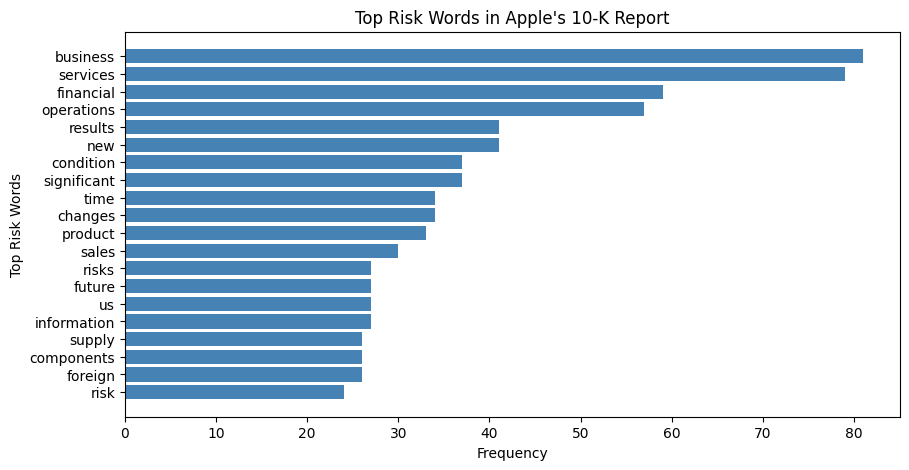

In [34]:
# 统计词频
word_counts = Counter(cleaned_risk.split())

# 取前 10 个高频风险词
top_words = word_counts.most_common(20)

# 拆分数据
words, counts = zip(*top_words)

# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.barh(words, counts, color="steelblue")  # 横向柱状图
plt.xlabel("Frequency")
plt.ylabel("Top Risk Words")
plt.title("Top Risk Words in Apple's 10-K Report")
plt.gca().invert_yaxis()  # 让频率最高的在最上面

plt.show()

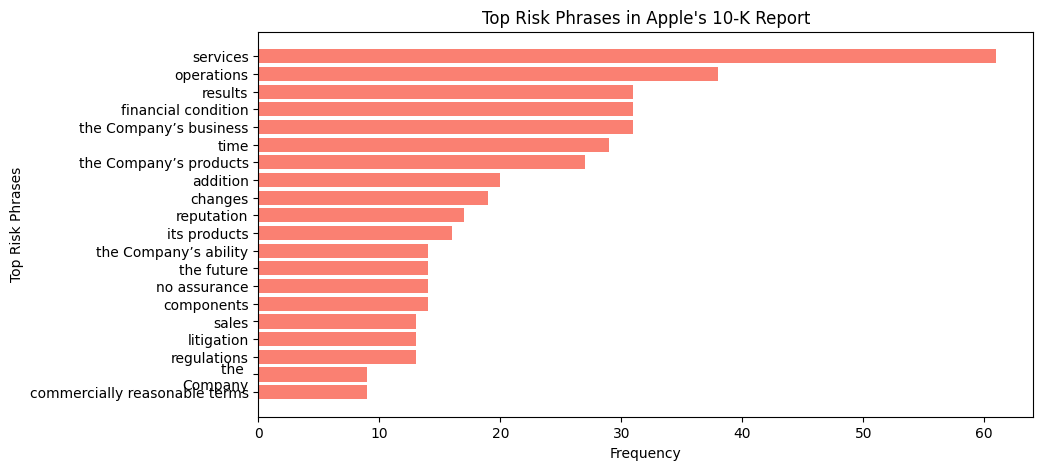

In [35]:
filtered_terms = [term for term in risk_noun_phrases if term.lower() not in stop_words]

term_counts = Counter(filtered_terms)  # 统计每个短语的出现次数

# 取前 10 个最高频短语
sorted_terms = term_counts.most_common(20)

# 拆分数据
words, counts = zip(*sorted_terms)

# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.barh(words, counts, color="salmon")
plt.xlabel("Frequency")
plt.ylabel("Top Risk Phrases")
plt.title("Top Risk Phrases in Apple's 10-K Report")
plt.gca().invert_yaxis()

plt.show()

## innovation analysis

In [36]:

keywords = {
    "Innovation Strategy": [r"\binnovation\b", r"\bresearch and development\b", r"\bintellectual property\b", r"\bdesign\b", r"\btechnology investment\b"],
    "GenAI": [r"\bAI\b", r"\bartificial intelligence\b", r"\bmachine learning\b", r"\bgenerative AI\b", r"\bApple Intelligence\b"],
    "EV": [r"\belectric vehicle\b", r"\bautonomous driving\b", r"\bProject Titan\b", r"\bcar\b", r"\bautomotive\b"],
    "Head-Mounted Display": [r"\bAR\b", r"\bVR\b", r"\bmixed reality\b", r"\bApple Vision Pro\b", r"\bspatial computing\b", r"\bheadset\b"]
}

# 搜索关键词并提取相关段落
def search_keywords(text, keywords):
    results = []
    for category, words in keywords.items():
        for word in words:
            matches = re.finditer(rf"(.{{0,300}}{word}.{{0,300}})", text,re.IGNORECASE)
            for match in matches:
                results.append({"Category": category, "Keyword": word, "Context": match.group(0)})
    return results

# 进行搜索
search_results = search_keywords(text_2024, keywords)

# 转换为DataFrame
df_results = pd.DataFrame(search_results)



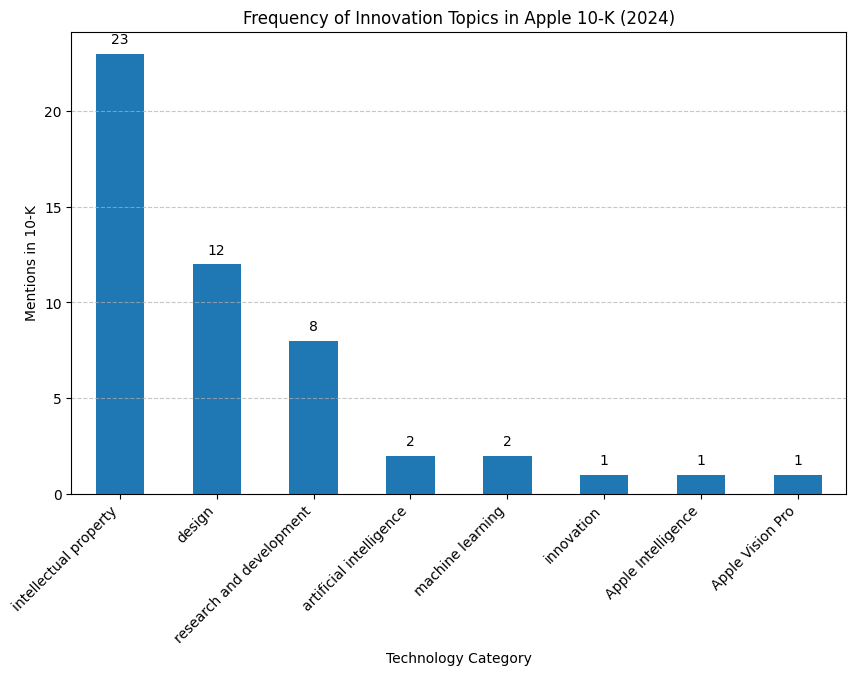

In [37]:
import matplotlib.pyplot as plt

# 统计每个类别的匹配次数
category_counts = df_results["Keyword"].value_counts()

category_labels = ["\bintellectual property\b", "\bdesign\b", "\bresearch and development\b", 
                   "\bartificial intelligence\b", "\bmachine learning\b", "\binnovation\b", 
                   "\bApple Intelligence\b", "\bApple Vision Pro\b"]

# 直接移除所有 `\b`
cleaned_labels = [label.replace("\b", "") for label in category_labels]



# 绘制柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bars = category_counts.plot(kind="bar", ax=ax)  # 在 ax 上绘制条形图

# 添加数据标签
ax.bar_label(bars.containers[0], fmt='%d', padding=5)  # %d 代表整数格式，padding 控制标签与柱子间距

# 添加标题和标签
ax.set_xlabel("Technology Category")
ax.set_ylabel("Mentions in 10-K")
ax.set_title("Frequency of Innovation Topics in Apple 10-K (2024)")

# 调整 X 轴标签
plt.xticks(ticks=range(len(cleaned_labels)), labels=cleaned_labels, rotation=45, ha="right")

# 添加网格线
plt.grid(True, linestyle="--", alpha=0.7, axis='y')

# 显示图表
plt.show()

In [ ]:
# Split the content into chunks
chunk_size = 200  # Adjust based on the model's token limit
content_chunks = [senti_section[i:i + chunk_size] for i in range(0, len(senti_section), chunk_size)]

parts = [text_2024[i:i + 50000] for i in range(0, len(text_2024), 50000)]


In [41]:
from openai import OpenAI
client = OpenAI(api_key="sk-04bfd612c8684b82bed6a142538de59d", base_url="https://api.deepseek.com")

In [42]:
# Create a conversation structure with a system message for noun phrase extraction
conversation = [
    {"role": "system", "content": "Please analyze Apple's innovation strategies and attitudes toward new technologies (e.g. GenAI, EV, Head-Mounted Display and so on) from the following text:"},
]

# Add content chunks with the "user" role
conversation.extend([{"role": "user", "content": business_section} ])

# Make an API call
response = client.chat.completions.create(
    model="deepseek-reasoner",  # Specify the appropriate model
    messages=conversation
)

# Extract the output
output = response.choices[0].message.content
print(output)

**Apple's Innovation Strategies and Attitudes Toward New Technologies: An Analysis**

**1. Vertical Integration and Ecosystem Control**  
Apple's innovation strategy is deeply rooted in **vertical integration**, designing nearly the entire solution for its products—hardware, operating systems (iOS, macOS, visionOS), software applications, and services. This approach allows tight control over the user experience and differentiation from competitors. For example:  
- **Apple Vision Pro**, a spatial computer powered by visionOS, exemplifies their investment in **head-mounted displays (HMDs)** and immersive technologies. The integration of custom hardware and software highlights their focus on creating seamless, proprietary ecosystems.  
- Services like Apple Pay, Apple Card, and Apple Arcade are tightly woven into their hardware, reinforcing ecosystem stickiness.

**2. R&D and Intellectual Property (IP) Focus**  
Apple prioritizes **R&D investments** to drive continuous innovation, as not